### Step 1 - Load Data

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
#import skvideo.io
import os

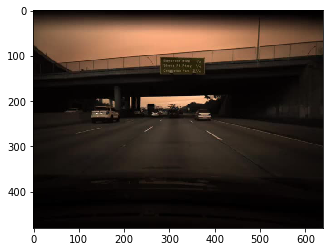

In [5]:
img = cv2.imread('data/images/image-0000001.jpg')
plt.imshow(img)
plt.show()

In [14]:
speed_list = list(map(float,open("data/train.txt").read().splitlines()))

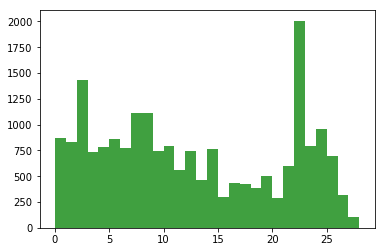

In [15]:
rounded = [round(speed) for speed in speed_list]
mn = 50
mx = 0
for num in rounded:
    mx = max(mx,num)
    mn = min(mn,num)
    
buckets = []
plt.hist(rounded, mx-mn, facecolor='g', alpha=0.75)
plt.show()

In [16]:
def opt_flow(frame1,frame2):
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    gray1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1,gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

#rgb = opt_flow(frame1,frame2)
#plt.imshow(rgb)

### Step 2: Data Augmentation

In [17]:
def rotate(img,angle):
    rows, cols, layers = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

def flip(img):
    return cv2.flip(img,1)

def crop(img,maxh,minh):
    copy = img[:,:,:]
    return copy[minh:maxh,:]

def resize(img,w,h):
    resized_image = cv2.resize(img, (w, h))
    return resized_image

read_dir = "data/images/image-"
write_dir = "data/processed/image-"
filetype = ".jpg"

num_digits = '07'

90 160


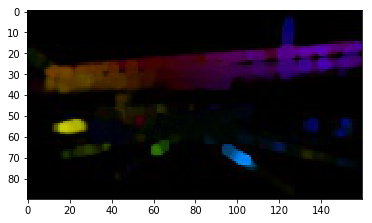

In [43]:
img = cv2.imread('data/processed/image-0000002.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(crop(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),360,0),(160,90))#,interpolation = cv2.INTER_LANCZOS4)
rows, cols , layers = img.shape
print(rows,cols)
plt.imshow(img)
plt.show()

In [19]:
num_images = 20399
images = []
for i in range(2,num_images+2):
    images.append(write_dir+format(i,num_digits)+filetype)
    
    
def non_shuffling_train_test_split(X, test_size=0.2):
    i_start = int(test_size/2*len(X) + 1)
    i_end = int((1 - test_size/2) * len(X) + 1)
    X_test1, X_train, X_test2 = np.split(X, [i_start,i_end])
    return (X_train, np.concatenate((X_test1, X_test2)))

def non_shuffling_train_test_split(X, test_size=0.2):
    i = int(test_size * len(X)) + 1
    X_test, X_train = np.split(X, [i])
    return X_train, X_test


train_data, validation_data = non_shuffling_train_test_split(images, test_size = 0.2)

import sklearn
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(images, test_size=0.2)

print(train_data[0])


validation_data = validation_data[:len(validation_data)-1]

print(len(validation_data),len(train_data))

data/processed/image-0018387.jpg
4079 16319


### Step 3: Generator

In [30]:
def get_img_num(filename):
    return int(str(filename).split('-')[1].split('.')[0])


print(get_img_num("a-001.c"))

num_aug = 10

def generator(speed_list,image_names, batch_size=64*num_aug):
    
    angles = np.arange(-6,7,3)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(image_names)
        # batch_size/10 because for each row we add 10 images
        for offset in range(0, len(image_names), int(batch_size/num_aug)):
            batch_lines = image_names[offset:offset+int(batch_size/num_aug)]
                        
            images = []
            speeds = []
            #print("New Batch ---")
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                #print(img_num)
                #print(img_num)
                img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                flipped = flip(img)
                """
                images.append(img)
                images.append(flipped)
                speeds.append(speed_list[img_num-1])
                speeds.append(speed_list[img_num-1])
                """
                
                for angle in angles:
                    images.append(rotate(img,angle))
                    speeds.append(speed_list[img_num-1])
                    images.append(rotate(flipped,angle))
                    speeds.append(speed_list[img_num-1])      
                    
            X_train = np.array(images)
            y_train = np.array(speeds)
            yield sklearn.utils.shuffle(X_train, y_train)

            
def valid_gen(speed_list,image_names, batch_size=10):
    
    while 1:
        for offset in range(0, len(image_names), int(batch_size)):
            batch_lines = image_names[offset:offset+int(batch_size)]
            
            images = []
            speeds = []
            
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                
                images.append(img)
                speeds.append(speed_list[img_num])
            
            X_valid = np.array(images)
            y_valid = np.array(speeds)
            yield sklearn.utils.shuffle(X_valid, y_valid)
            
            
    

1


Good Model

In [34]:


#X_data,y_data = next(train_generator)
#print(X_data.shape,y_data.shape)
#plt.imshow(X_data[0])
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

train_generator = generator(speed_list,train_data)
validation_generator = generator(speed_list,validation_data)
input_shape = (90,160,3)

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'),
    ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto'),
]

num_epochs = 50

In [ ]:
# Ran this one. Current best model is models/model.h5
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dense(100 , activation='elu'))
model.add(Dense(50,  activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))


model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=num_epochs,callbacks = callbacks,verbose=1)
model.save('models/last_comma.h5')


In [ ]:
#Bad Model
#Booo
#Don't run it
input_shape = (90,160,3)
model = Sequential()

model.add(Lambda(lambda x: x / 255 - 0.5, input_shape = input_shape))
#model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample = (2,2),activation = "selu"))
model.add(Convolution2D(36,5,5,subsample = (2,2),activation = "selu"))
model.add(Convolution2D(48,5,5,subsample = (2,2),activation = "selu"))
model.add(Convolution2D(64,3,3,activation = "selu"))
model.add(Convolution2D(64,3,3,actsivation = "selu"))

model.add(Flatten())
model.add(Dense(100 , activation='selu'))
model.add(Dense(50,  activation='selu'))
model.add(Dense(10, activation='selu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=num_epochs,callbacks = callbacks,verbose=1)
model.save('models/last_nvidia.h5')

In [42]:
from keras.models import load_model
model = load_model("models/model.h5")

img = cv2.imread('data/processed/image-0020388.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(crop(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),360,0),(160,90))#,interpolation = cv2.INTER_LANCZOS4)
img = img[None,:]
print(img.shape)
print(model.predict(img))

(1, 90, 160, 3)
[[ 7.36340094]]


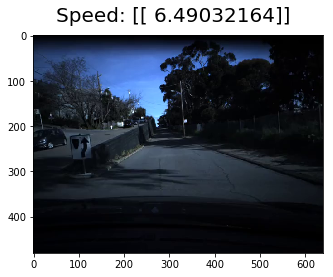

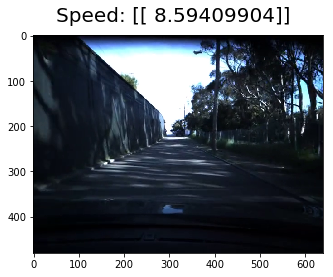

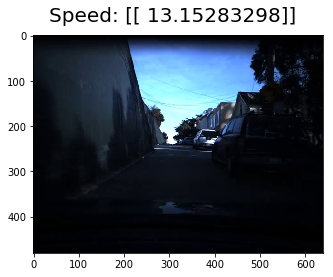

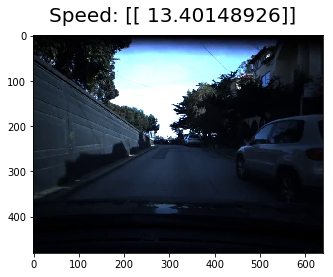

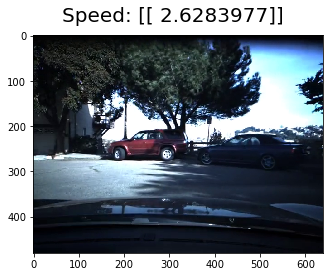

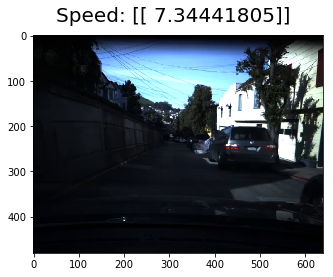

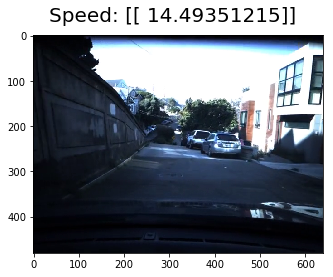

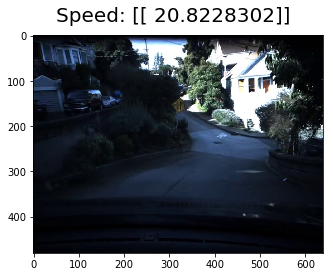

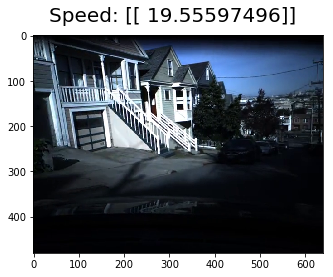

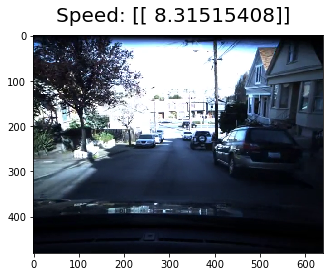

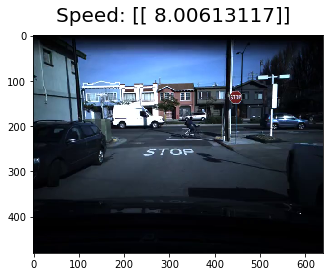

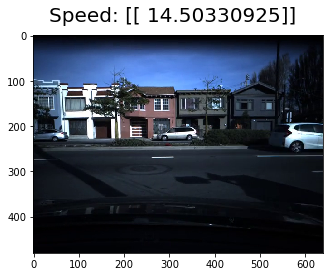

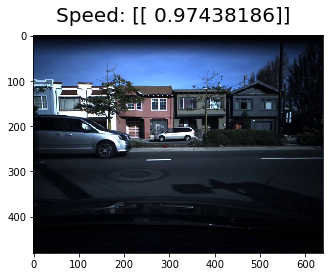

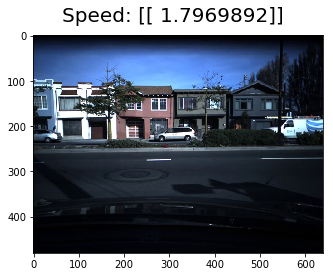

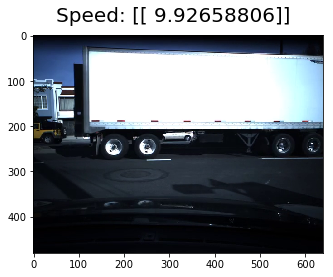

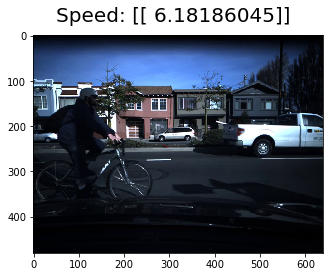

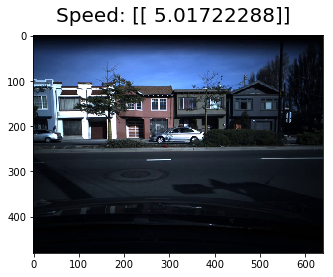

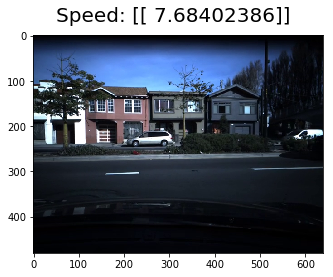

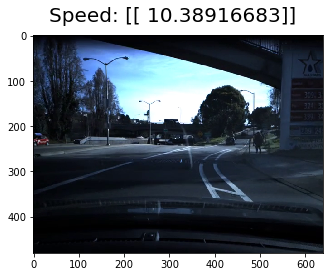

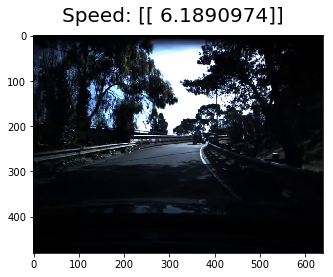

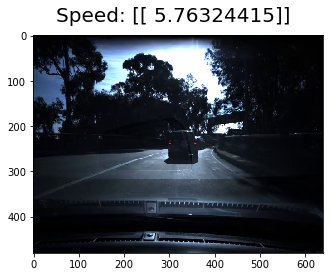

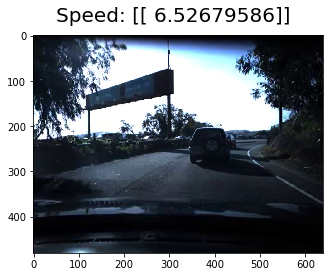

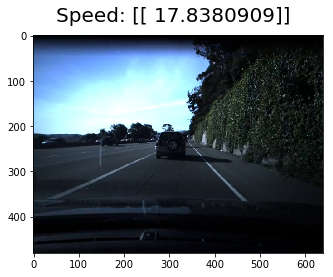

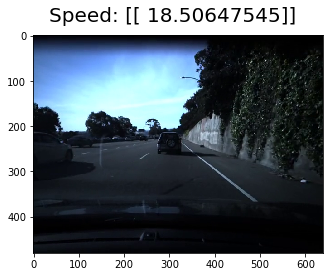

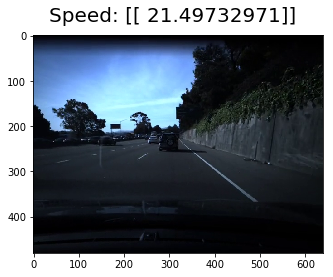

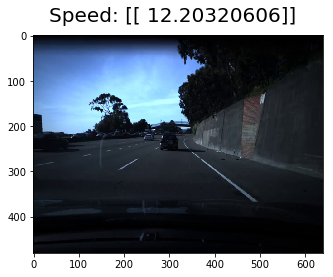

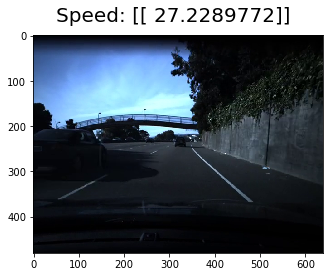

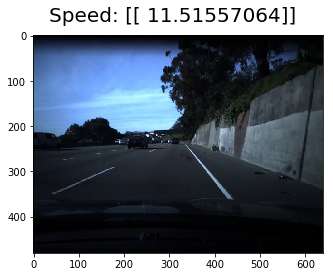

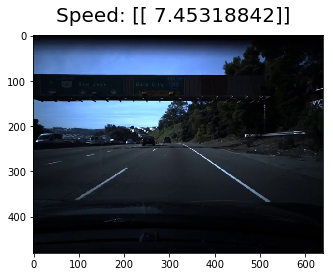

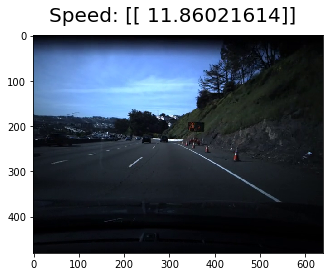

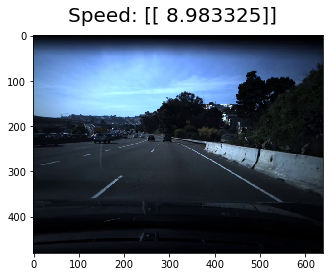

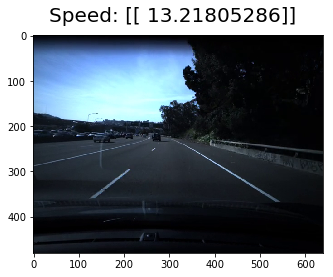

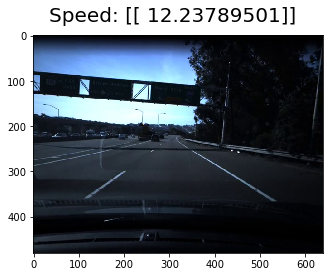

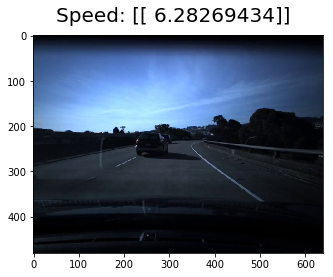

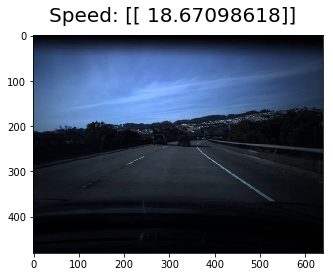

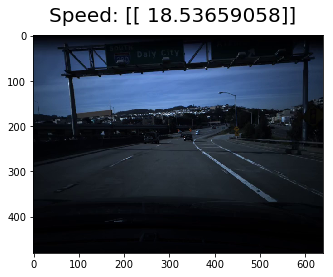

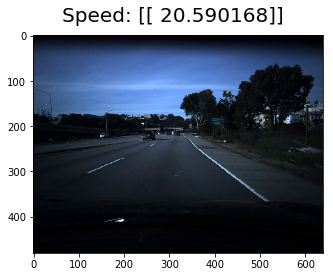

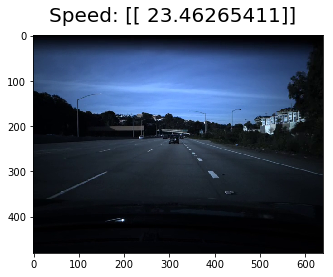

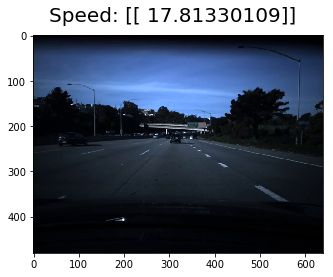

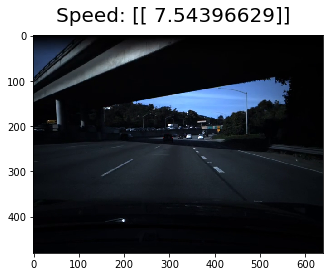

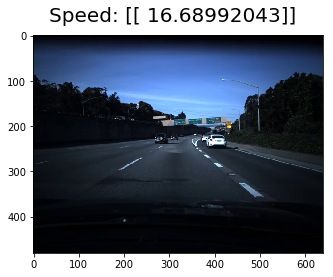

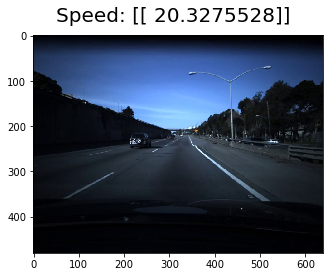

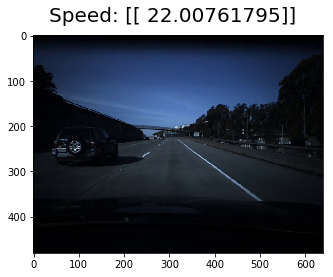

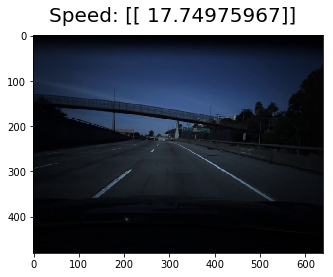

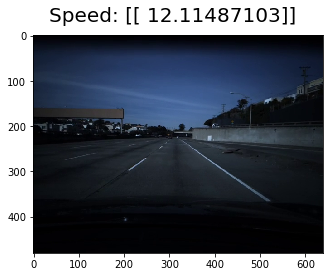

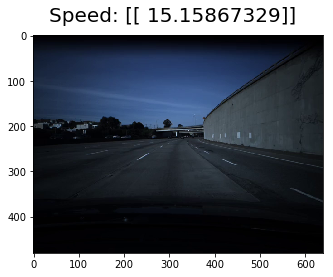

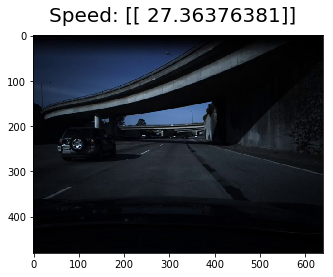

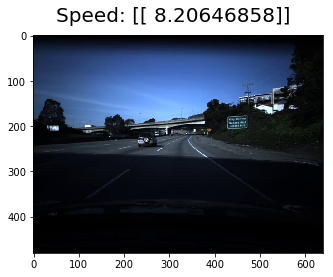

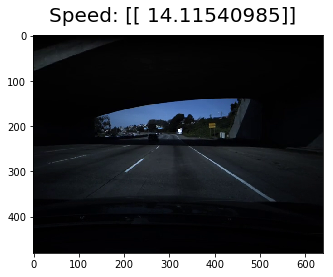

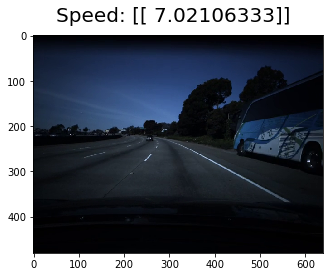

In [45]:
import pylab
import imageio
filename = 'data/test.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')

for i in range(0,5000,100):
    try:
        f1 = vid.get_data(i)
        f2 = vid.get_data(i+1)
        
    except:
        print("End of Video")
        break
    test_img = cv2.resize(crop(opt_flow(f1,f2),360,0),(160,90))
    y = model.predict(test_img[None,:])
    fig = pylab.figure()
    fig.suptitle('Speed: {}'.format(y), fontsize=20)
    plt.imshow(f1)
    plt.show()
        

In [ ]:
`